### Gaussian mixture model example

In [3]:
import os
import torch
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
from cplAE_MET.utils.plots import plot_z_3d
from cplAE_MET.utils.utils import loadpkl

In [4]:
# Generate some data
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

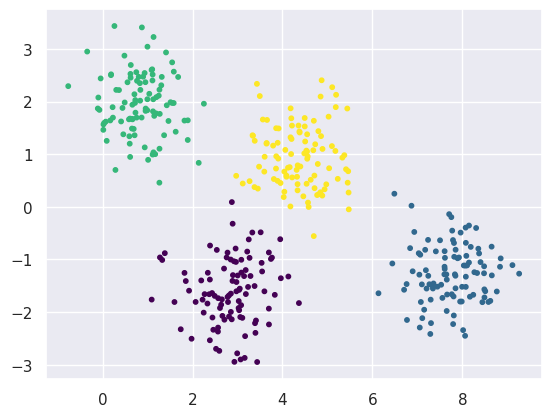

In [10]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

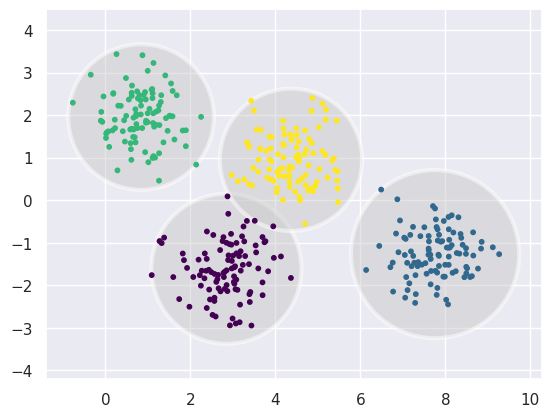

In [13]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

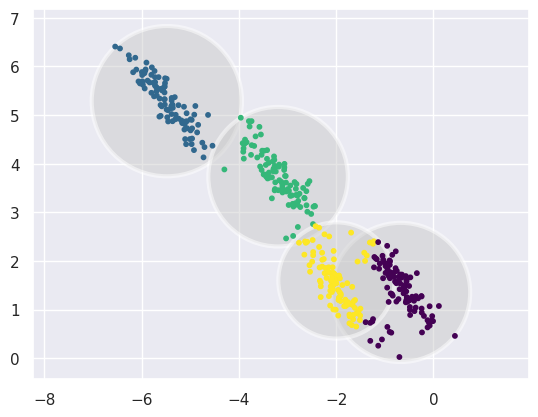

In [14]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

hese two disadvantages of k-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

### Generalizing E-M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

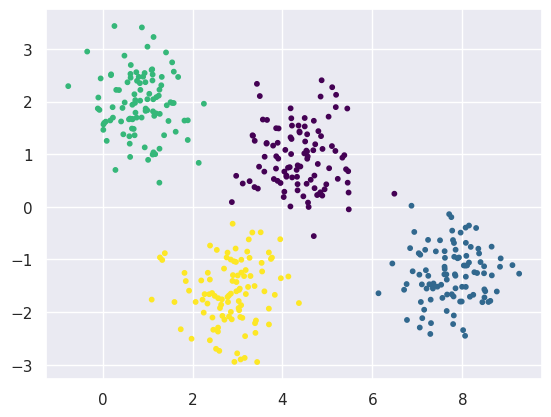

In [21]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [18]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.537 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

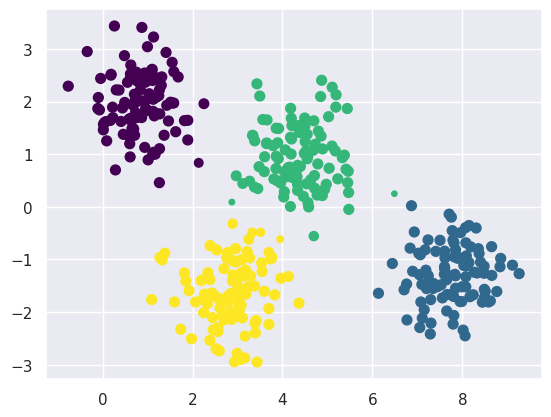

In [19]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

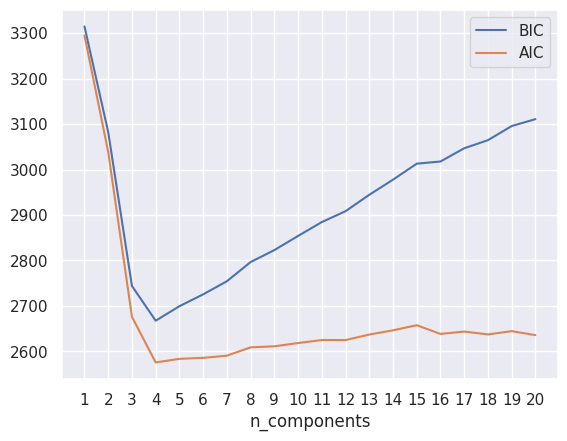

In [25]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(np.arange(1,21))
plt.show()

Now lets load one of our models and see how gmm works on that:

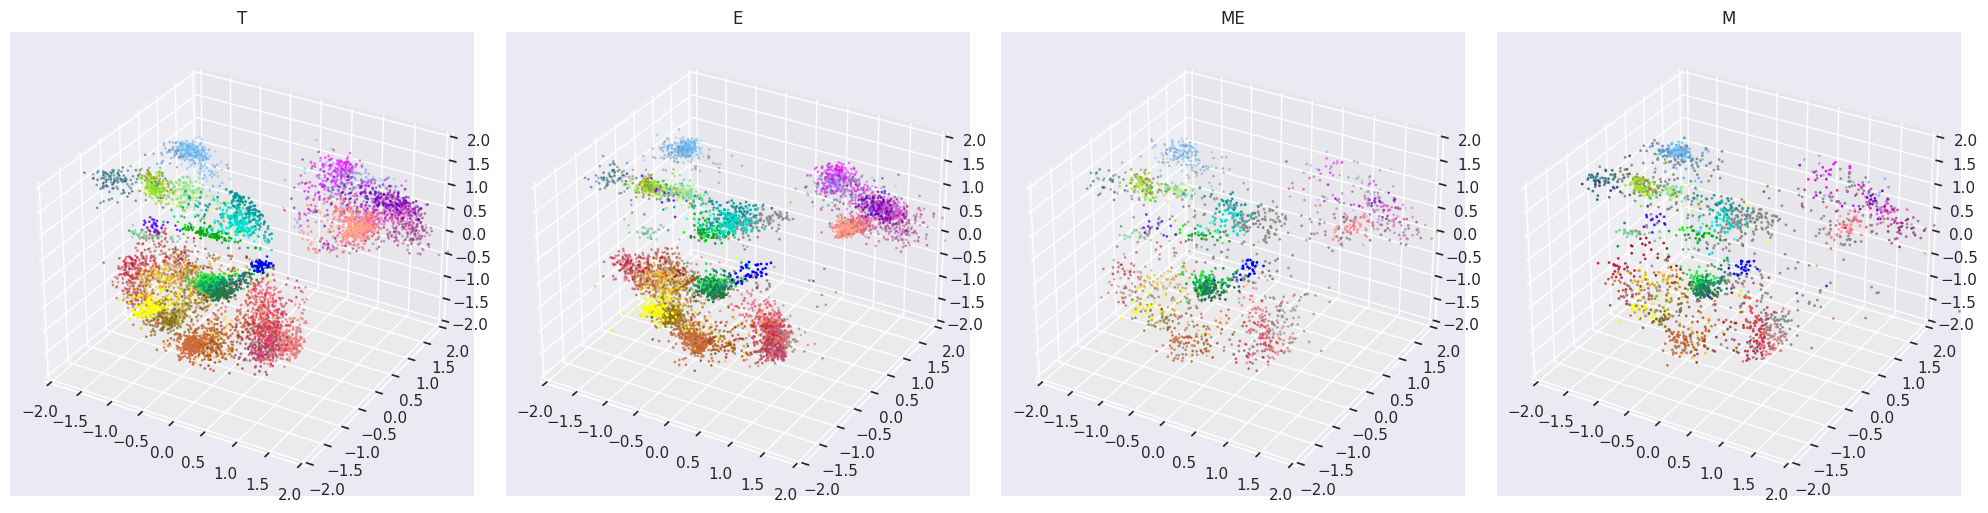

In [26]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80M_scaled_PCs_83EPCs_no_noise_no_drp_v2"
file= "checkpoint_ep_34500_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z_3d(output, xlim=(-2., 2.), ylim=(-2., 2.), zlim=(-2.,2.))

Lets first apply it on T embding:

In [27]:
output['zt']

array([[ 1.5131295 , -0.4337608 , -0.5486312 ],
       [ 1.5440695 , -0.5640791 , -0.60442084],
       [ 1.15306   ,  0.06918927, -0.120552  ],
       ...,
       [ 0.03276848,  0.49811348,  0.03046496],
       [ 0.03276848,  0.49811348,  0.03046496],
       [ 0.03276848,  0.49811348,  0.03046496]], dtype=float32)

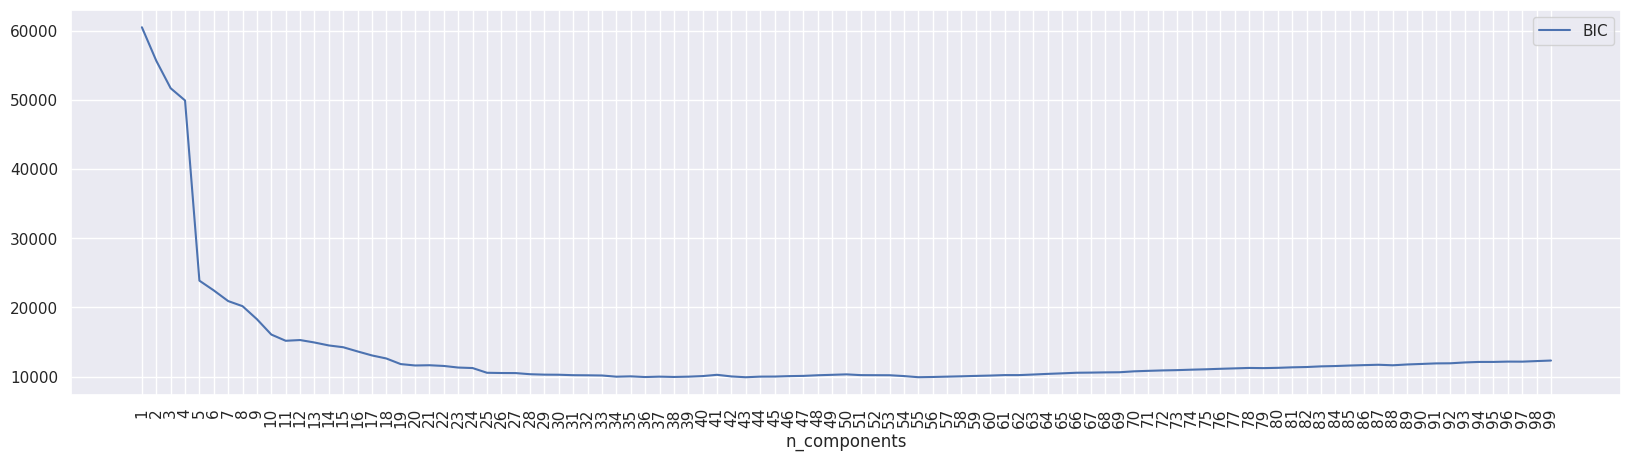

In [43]:
X = output['zt']
n_components = np.arange(1, 100)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.figure(figsize=(20,5))
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(np.arange(1,100), rotation=90)
plt.show()

In [44]:
gmm_t_types = np.argmin([m.bic(X) for m in models])
print(gmm_t_types)

42


We compute the number of clusters on the e embedding for only cells that have t types.

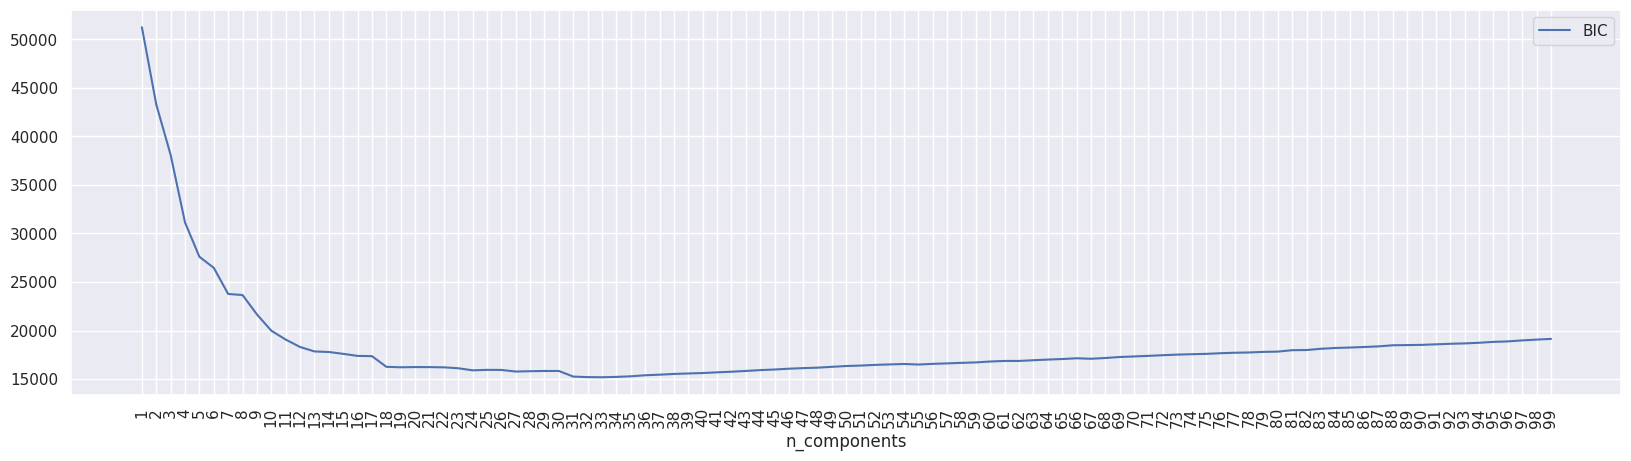

In [45]:
is_t_1d = output['is_t_1d']
is_e_1d = output['is_e_1d']
is_m_1d = output['is_m_1d']
is_te_1d = np.logical_and(is_t_1d, is_e_1d)
is_tm_1d = np.logical_and(is_t_1d, is_m_1d)
is_tme_1d = np.logical_and(is_m_1d, is_te_1d)

X = output['ze'][is_te_1d]
n_components = np.arange(1, 100)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.figure(figsize=(20,5))
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(np.arange(1,100), rotation=90)
plt.show()

In [46]:
gmm_e_types = np.argmin([m.bic(X) for m in models])
print(gmm_e_types)

32


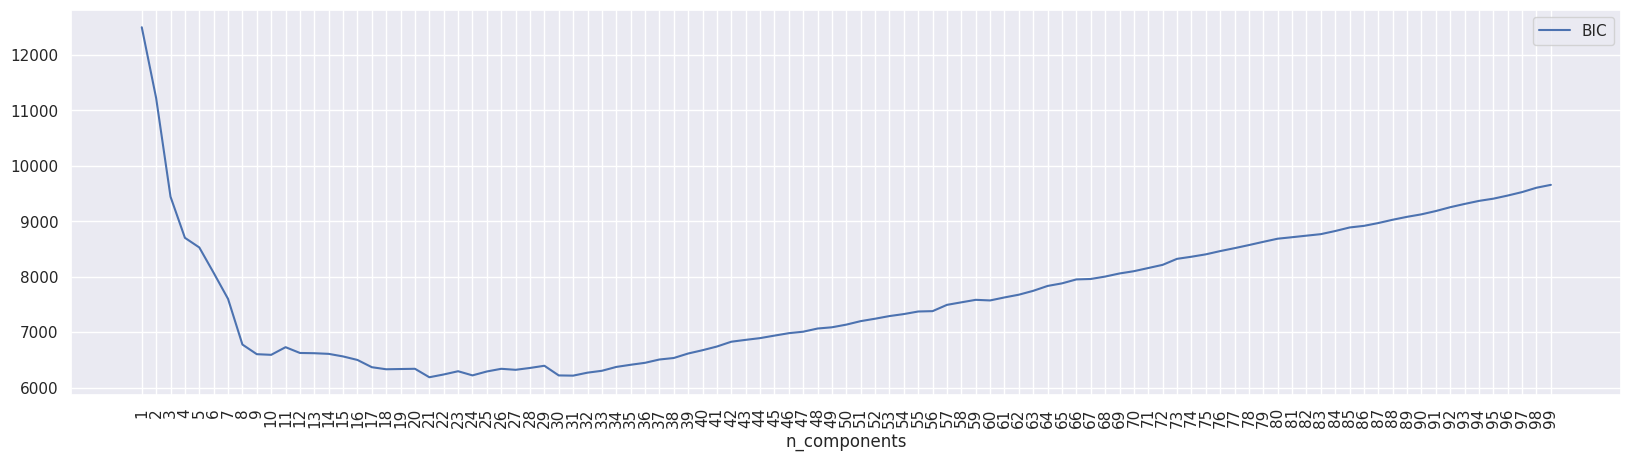

In [47]:
X = output['zme_paired'][is_tme_1d]
n_components = np.arange(1, 100)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.figure(figsize=(20,5))
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(np.arange(1,100), rotation=90)
plt.show()

In [48]:
gmm_me_types = np.argmin([m.bic(X) for m in models])
print(gmm_me_types)

20


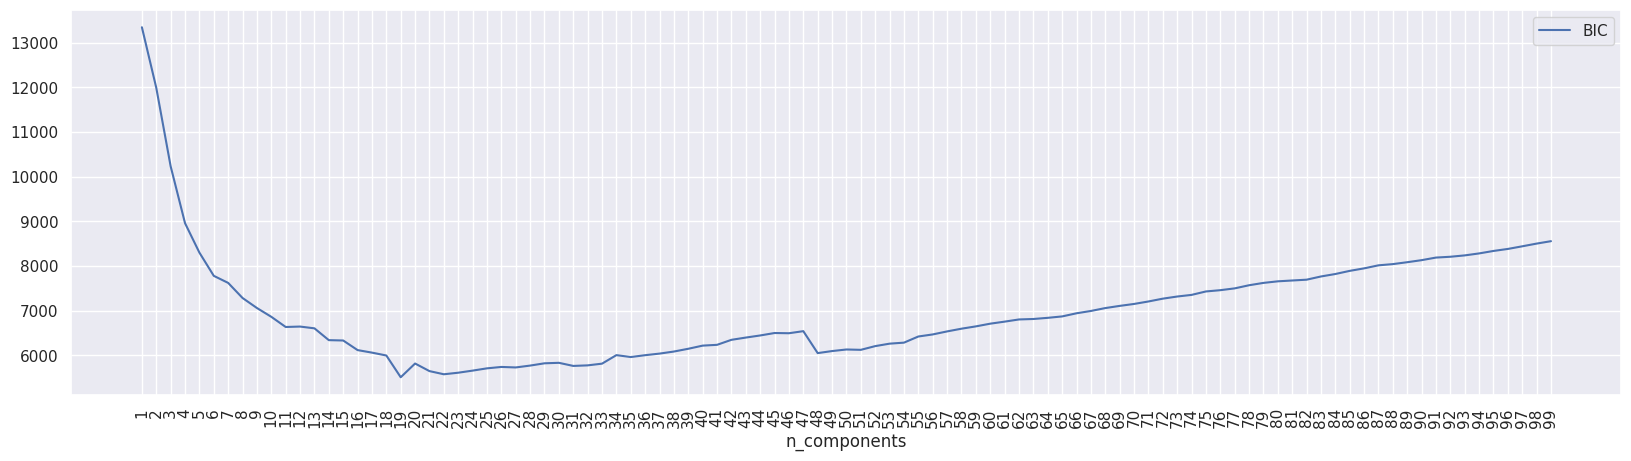

In [49]:
X = output['zm'][is_tm_1d]
n_components = np.arange(1, 100)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.figure(figsize=(20,5))
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(np.arange(1,100), rotation=90)
plt.show()

In [50]:
gmm_m_types = np.argmin([m.bic(X) for m in models])
print(gmm_m_types)

18
